In [1]:
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from tqdm import tqdm

In [65]:
datadir = '/home/nute11a/dataset/CT/original/VESSEL12/8055066/data'
annodir = '/home/nute11a/dataset/CT/original/VESSEL12/8055066/annotations'
savedir = '/home/nute11a/dataset/CT/original/VESSEL12/8055066/annotations2'
savedir2 = '/home/nute11a/dataset/CT/original/VESSEL12/8055066/data2'

def normalizePlanes(npzarray):
        """
        Normalizing the image using the appropriate maximum and minimum values associated 
        with a CT scan for lung cancer (in terms of Hounsfeld Units)
        
        """
        max_hu = np.max(npzarray)
        min_hu= np.min(npzarray)#-1000.
        npzarray = (npzarray - min_hu) / (max_hu - min_hu)
        npzarray[npzarray>1] = 1.
        npzarray[npzarray<0] = 0.
        return npzarray

for anno in tqdm(os.listdir(annodir)):
    #print(anno)
    if '.mhd' not in anno: continue
    # 해당 폴더 생성
    os.makedirs(f"{savedir}/{anno.replace('.mhd', '')}", exist_ok=True)
    os.makedirs(f"{savedir2}/{anno.replace('.mhd', '')}", exist_ok=True)
    # 파일 읽기
    mhd, mhd_img = sitk.ReadImage(f'{annodir}/{anno}'), sitk.ReadImage(f'{datadir}/{anno}')
    image_array, image_array_img = sitk.GetArrayViewFromImage(mhd), sitk.GetArrayViewFromImage(mhd_img)
    # png로 저장
    if image_array.shape != image_array_img.shape:
        print('NOT SUIT : ', anno)
        break
    c, h, w = image_array.shape
    for _c in range(c):
        img = image_array[_c]
        ratio = (np.count_nonzero(img) / (h * w)) * 100
        if ratio < 0.153: continue
        # (2) 객체 분리
        contours, _ = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnt, is_save_img = 0, False
        for con in contours:
            mask_zeros = np.zeros([h, w, 1], dtype=np.uint8)
            cv2.fillPoly(mask_zeros, [con], 255)
            if (np.count_nonzero(mask_zeros) / (h * w))*100 < 0.153: continue
            mask_zeros = np.repeat(mask_zeros, 3, axis = 2)
            cv2.imwrite(f'{savedir}/{anno.replace(".mhd", "")}/{_c}_{cnt}.png', mask_zeros)
            cnt += 1
            is_save_img = True
        if is_save_img:
            image = normalizePlanes(image_array_img[_c])    #  [ :, :, 13]
            cv2.imwrite(f'{savedir2}/{anno.replace(".mhd", "")}/{_c}.png', image*255)
        #for x in np.unique(img).tolist(): pixs.append(x)
        #cv2.imwrite(f"{savedir}/{anno.replace('.mhd', '')}/{_c}.png", img * 255)
    #print(set(pixs))


100%|██████████| 40/40 [01:48<00:00,  2.71s/it]


(17, 512, 512)


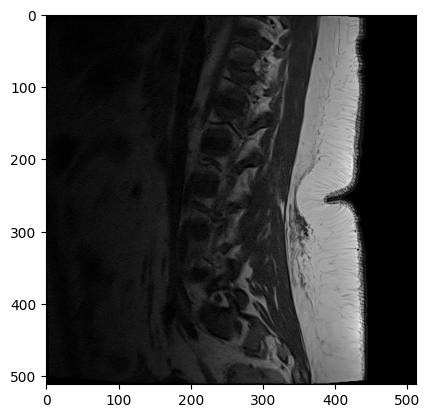

In [61]:
import json
from glob import glob
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from tqdm import tqdm
import custom_utils as cutils
import read_utils as rutils

def normalizePlanes(npzarray):
        """
        Normalizing the image using the appropriate maximum and minimum values associated 
        with a CT scan for lung cancer (in terms of Hounsfeld Units)
        
        """
        max_hu = np.max(npzarray)
        min_hu= np.min(npzarray)#-1000.
        npzarray = (npzarray - min_hu) / (max_hu - min_hu)
        npzarray[npzarray>1] = 1.
        npzarray[npzarray<0] = 0.
        return npzarray

CLASSES_NAME = {
        "0": "background",
        "1": "vertebrae1",
        "2": "vertebrae2",
        "3": "vertebrae3",
        "4": "vertebrae4",
        "5": "vertebrae5",
        "6": "vertebrae6",
        "7": "vertebrae7",
        "100": "SC",
        "201": "IVD1",
        "202": "IVD2",
        "203": "IVD3",
        "204": "IVD4",
        "205": "IVD5",
        "206": "IVD6",
        "207": "IVD7"
    }
def saveMask(mask, saveMaskRoot, saveMaskPatient, z_axis, h, w, clsNames):
    is_save_img = False
    #! Multi-class 처리
    # 1. class 추출
    classes = np.unique(mask).tolist()
    #print(classes)
    classes.remove(0)           # 0: background
    # 2. 각 class별 mask 저장
    for cls in classes:
        mask_cls = cutils.exploit_mask(mask, cls) # 해당 cls의 label만 추출
        #! 동일 class multi-object 처리
        eq_cls_cnt = 0
        mask_cls = mask_cls.astype(np.uint8)
        contours, _ = cv2.findContours(mask_cls, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        for con in contours:
            mask_zeros = np.zeros([h, w, 1], dtype=np.uint8)
            cv2.fillPoly(mask_zeros, [con], 255)
            if not cutils.checkRatio(mask_zeros, h, w): continue
            mask_zeros = np.repeat(mask_zeros, 3, axis = 2)
            mask_zeros = mask_zeros.astype(np.float32)
            if type(clsNames) == type({}):
                cv2.imwrite(f'{saveMaskRoot}/{saveMaskPatient}/{z_axis}_{int(cls)}_{clsNames[str(int(cls))]}_{eq_cls_cnt}.png', mask_zeros)
            else:
                cv2.imwrite(f'{saveMaskRoot}/{saveMaskPatient}/{z_axis}_{int(cls)}_{clsNames[int(cls)]}_{eq_cls_cnt}.png', mask_zeros)
            eq_cls_cnt += 1                # 동일 class의 다른 객체들 처리해주기 위한 idx
            is_save_img = True      # mask 저장시 -> 무조건 img도 저장
    return is_save_img


filesSeg = '/home/nute11a/dataset/MR/SPIDER/labelsTr/22_t1.mha'
filesImg = '/home/nute11a/dataset/MR/SPIDER/imagesTr/22_t1.mha'
patientName = filesSeg.split('/')[-1].replace('.mha', "")

itk_seg, itk_image = sitk.ReadImage(filesSeg), sitk.ReadImage(filesImg)
segdata, imgdata = sitk.GetArrayViewFromImage(itk_seg), sitk.GetArrayViewFromImage(itk_image)
m = imgdata.copy()
print(m.shape)
#pixs = np.unique(m).tolist()
#print(pixs)
#m[m != 4] = 0
#print(np.unique(m))
image = normalizePlanes(m[13, :, :])    #  [ :, :, 13]
#print(np.unique(image))
cv2.imwrite('./ffffff.png', image*255)
plt.imshow(image, cmap='gray')

In [ ]:
itk_seg, itk_image = sitk.ReadImage(filesSeg), sitk.ReadImage(filesImg)
seg_array, image_array = sitk.GetArrayViewFromImage(itk_seg), sitk.GetArrayViewFromImage(itk_image)
print(seg_array.shape)
h, w, z = seg_array.shape
for _z in range(z):
    #if cfg["format"] in ['.nii.gz', '.nrrd', '.nii']:
    mask, img = seg_array[:,:,_z], image_array[:,:,_z]
    
    if not cutils.checkRatio(mask, h, w):   continue
    ##* mask 처리
    is_save_img = saveMask(mask, "../dataset/MR/SPIDER/labelsTr_png", patientName, _z, h, w, CLASSES_NAME)
    ##* image 처리
    if is_save_img:
        cv2.imwrite(f'{"../dataset/MR/SPIDER/imagesTr_png"}/{patientName}/{_z}.png', img)

In [64]:
from glob import glob
from tqdm import tqdm
import os
import numpy as np
import cv2
import json
import SimpleITK as sitk
import custom_utils as cutils
import read_utils as rutils

def normalizePlanes(npzarray):
        """
        Normalizing the image using the appropriate maximum and minimum values associated 
        with a CT scan for lung cancer (in terms of Hounsfeld Units)
        
        """
        max_hu = np.max(npzarray)
        min_hu= np.min(npzarray)#-1000.
        npzarray = (npzarray - min_hu) / (max_hu - min_hu)
        npzarray[npzarray>1] = 1.
        npzarray[npzarray<0] = 0.
        return npzarray

def getImageFiles(segfiles, ds):
    if ('MSD-' in ds) or (ds == 'PASeg') or (ds == 'SPIDER'):
        return [seg.replace('labelsTr', 'imagesTr') for seg in segfiles]
    if ds == 'ATLAS2023':
        return [seg.replace('labelsTr', 'imagesTr').replace('Tr/lb', 'Tr/im') for seg in segfiles]
    if ds == 'TDSC-ABUS2023':
        return [seg.replace('labelsTr', 'imagesTr').replace('MASK', 'DATA') for seg in segfiles]
    if ds == 'RESECT(US)':
        return [seg.replace('labelsTr', 'imagesTr').replace('-after-resection', '-after').replace('-before-tumor', '-before').replace('-during-resection', '-during') for seg in segfiles]
    if ds == 'LiTS17':
        return [seg.replace('labelsTr', 'imagesTr').replace('segmentation', 'volume') for seg in segfiles]
    if ds == '3DLSC-COVID':
        return [seg.replace('labelsTr', 'imagesTr').replace('.nii', '.nii.gz') for seg in segfiles]
    if ds == 'SegRap2023-Task001' or ds == 'SegRap2023-Task002':
        imgs, task = [], ds.split('-')[-1]
        for seg in segfiles:
            case = seg.split('/')[-1].replace('.nii.gz', '')
            imgs.append(seg.replace('SegRap2023_Training_Set_120cases_OneHot_Labels', 'SegRap2023_Training_Set_120cases').replace(case, 'image_contrast').replace(task, case))
        return imgs
    
def saveMask(mask, saveMaskRoot, saveMaskPatient, z_axis, h, w, clsNames):
    is_save_img = False
    #! Multi-class 처리
    # 1. class 추출
    classes = np.unique(mask).tolist()
    #print(classes)
    classes.remove(0)           # 0: background
    # 2. 각 class별 mask 저장
    for cls in classes:
        mask_cls = cutils.exploit_mask(mask, cls) # 해당 cls의 label만 추출
        #! 동일 class multi-object 처리
        eq_cls_cnt = 0
        mask_cls = mask_cls.astype(np.uint8)
        contours, _ = cv2.findContours(mask_cls, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        for con in contours:
            mask_zeros = np.zeros([h, w, 1], dtype=np.uint8)
            cv2.fillPoly(mask_zeros, [con], 255)
            if not cutils.checkRatio(mask_zeros, h, w): continue
            mask_zeros = np.repeat(mask_zeros, 3, axis = 2)
            mask_zeros = mask_zeros.astype(np.float32)
            if type(clsNames) == type({}):
                cv2.imwrite(f'{saveMaskRoot}/{saveMaskPatient}/{z_axis}_{int(cls)}_{clsNames[str(int(cls))]}_{eq_cls_cnt}.png', mask_zeros)
            else:
                cv2.imwrite(f'{saveMaskRoot}/{saveMaskPatient}/{z_axis}_{int(cls)}_{clsNames[int(cls)]}_{eq_cls_cnt}.png', mask_zeros)
            eq_cls_cnt += 1                # 동일 class의 다른 객체들 처리해주기 위한 idx
            is_save_img = True      # mask 저장시 -> 무조건 img도 저장
    return is_save_img


def main(config_file):
    #* (1) read data config file
    with open(config_file, 'rb') as f:
        cfg = json.load(f)
    
    #* (2) images/labels 얻기
    filesSeg = glob(cfg["segP"])
    filesImg = getImageFiles(filesSeg, cfg["dataset_name"])

    #* (3) 3D -> 2D convert/save
    for idx in tqdm(range(len(filesSeg))):
        imgName, segName = filesImg[idx], filesSeg[idx]
        patientName = segName.split('/')[-1].replace(cfg["format"], "")
        os.makedirs(f"{cfg['save_imgP']}/{patientName}", exist_ok=True)
        os.makedirs(f"{cfg['save_segP']}/{patientName}", exist_ok=True)
        #* 파일 읽기
        #segdata, imgdata = sitk.ReadImage(segName), sitk.ReadImage(segName)
        #segdata, imgdata = sitk.GetArrayViewFromImage(segdata), sitk.GetArrayViewFromImage(imgdata)
        #_, segdata = rutils.read_by_format(segName, cfg["format"])
        #_, imgdata = rutils.read_by_format(imgName, cfg["format"])
        itk_seg, itk_image = sitk.ReadImage(segName), sitk.ReadImage(imgName)
        segdata, imgdata = sitk.GetArrayViewFromImage(itk_seg), sitk.GetArrayViewFromImage(itk_image)
        #print(segName, segdata.shape, imgdata.shape)
        if cfg["dataset_name"] == "PASeg":
            imgdata = imgdata[ : , : , : , 0]   # [x, y, z, 1] -> [x, y, z]
        # check
        if imgdata.shape != segdata.shape:
            print('NOT SUIT : ', segName)
            break
        #if cfg["format"] in ['.nii.gz', '.nrrd', '.nii']:
        if segdata.shape[0] > segdata.shape[-1]:
            h, w, z = segdata.shape
        else:
            z, h, w = segdata.shape

        #elif cfg["format"] in ['.mha', '.mhd']:
            #z, h, w = segdata.shape
        #print(filesSeg[idx], ' > ', np.unique(segdata))
        #! 2D img로 보기 - z divide
        for _z in range(z):
            #if cfg["format"] in ['.nii.gz', '.nrrd', '.nii']:
            if segdata.shape[0] > segdata.shape[-1]:
                mask, img = segdata[:,:,_z], imgdata[:,:,_z]
            else:
                mask, img = segdata[_z], imgdata[_z]
            if not cutils.checkRatio(mask, h, w):   continue
            #* mask 처리
            is_save_img = saveMask(mask, cfg["save_segP"], patientName, _z, h, w, cfg["CLASSES_NAME"])
            #* image 처리
            if is_save_img:
                image = normalizePlanes(img)    #  [ :, :, 13]
                cv2.imwrite(f'{cfg["save_imgP"]}/{patientName}/{_z}.png', image*255)

if __name__ == "__main__":
    main(
        config_file = './configs/SPIDER.json'
    )

  0%|          | 0/41 [00:00<?, ?it/s]

100%|██████████| 41/41 [02:18<00:00,  3.37s/it]
